# Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning, and more specifically about dimensionality reduction using the PCA and ICA algorithms. You will first work on toy examples, and then apply the methods on a real face dataset.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`).

First let's load the functions we will use

In [54]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm


import math

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.io import loadmat

# I - Toy examples
## I - 1) Dataset generation

As mentionned, you will first work on toy datasets. The next three functions are used to generate the data and plot the results.

In [55]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1:
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')

    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T

        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)

    N0=np.sum(y==0)
    N1=np.sum(y==1)

    fig=plt.figure(figsize=(17, 6))

    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()

    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')

    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')

    plt.show()


def frontiere(model, X, y, step=50):

    labels = np.unique(y)

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)

    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')

    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')

    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])


Now,let's create the data we will use.
Try the 4 different scenarios by simply varying the `scenarioIndex` value between 1 and 4.

**Question** : what does each scenario corresponds to?

**Answer** :
* Le premier scénario correspond à un set de données séparées par des axes en deux classes (0 et 1)
* Le second est semblable au premier bien que la distinction soit moins claire, les deux classes se chevauchant au niveau de l'axe.
* Le troisième scénario correspond à une séparation des classes selon des lignes : une ligne horizontale pour la classe 0 et une ligne verticale pour la classe 1.
* Le quatrième et dernier scénario correspond à une répartition des points des classes en cercles de rayons différents et centrés. Les points de la classes 1 se trouvent à l'intérieur du cercle des points de la classe 0.

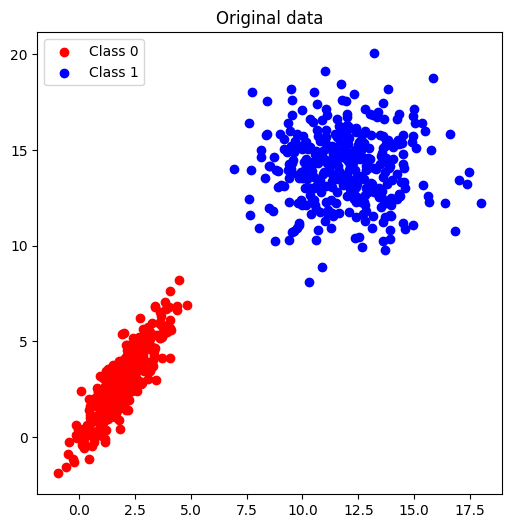

In [70]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 1
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

## I - 2) PCA

**BASIC PCA**

It's time to start using the methods seen in class. Let's start with PCA.


As you can see, we have generated two populations (class 0 and class 1). We concatenate them as a single matrix *X* which will be the input for all methods. In this way, the methods will be unaware of the class of the observations (unsupervised) and we will test whether the methods are appropriate for the analysed scenario and if they are able to use less dimensions to correctly distinguish the two classes.


**Question:**
1. Use PCA with the different 4 scenarios and comment the results. When does PCA work well ? Why ? Expain.

The variance explained by the two first modes is respectively:  [0.96673834 0.03326166]


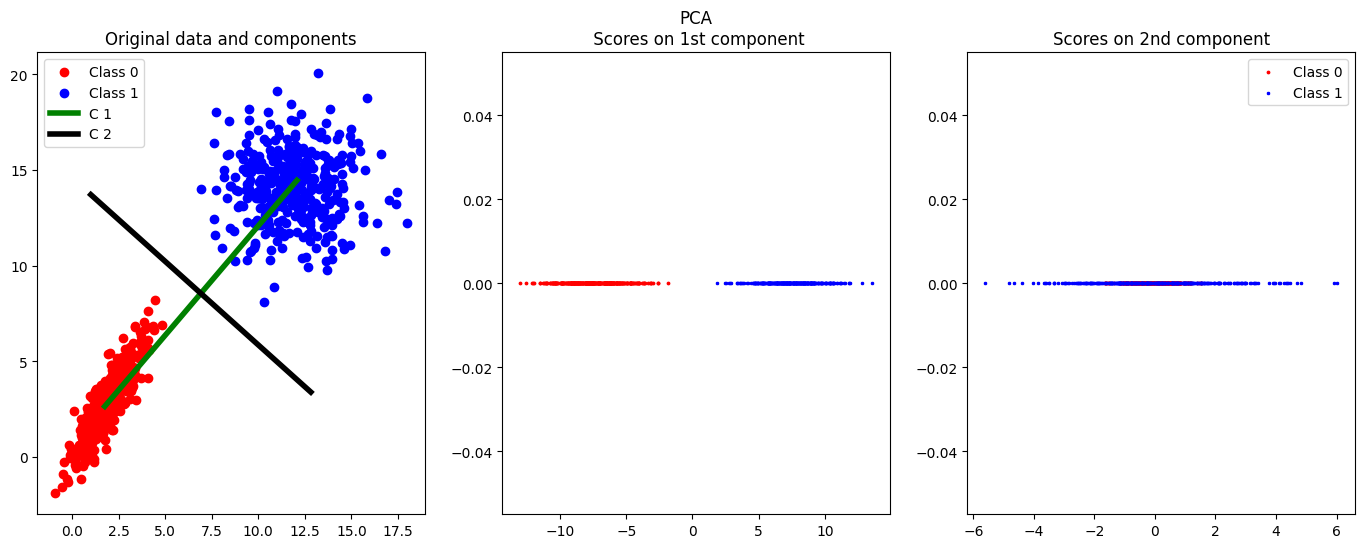

In [71]:
## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [72]:
def pcaLecture(X):
    '''
    Inputs:
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.

            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)

            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.
    '''

    N=X.shape[0]
    Xc=X-np.mean(X, axis=0)
    _, D2, Uh = LA.svd(Xc) # computation of eigenvectors and eigenvalues using SVD
    U=Uh.T
    Y=Xc@U # computation of the scores
    D=D2**2/(N-1) # computation of the eigenvalues
    tot=np.sum(D)
    var_explained = D / tot # computation of explained variance

    return Y,U,D,var_explained


**Question:**
1. Test your own implementation and check whether the results are the same of the scikit-learn implementation

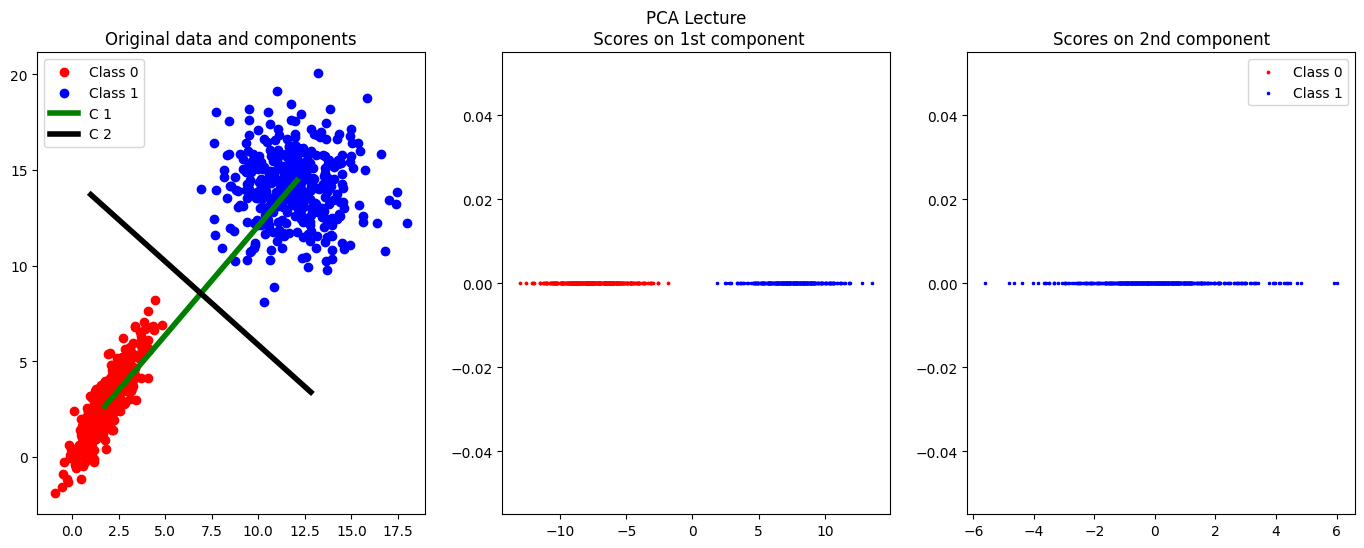

In [73]:
YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')


> The results are the same.

**KERNEL PCA**

Let's now use Kernel-PCA with the rbf kernel (you can also test other kernels if you want).

**Question:**
1. What is the interest of kernel PCA over the basic PCA?
2. Use Kernel-PCA with the different 4 scenarios and comment the results. When does K-PCA work well ? Why ?

**Answer**
1. Le K-PCA permet de séparer des données non linéairement séparables en les projetant sur une dimension supérieure.
2. Le K-PCA fonctionne pour séparer les classes des scénarios 1 et 4 avec une valeur de $\gamma = 0,1$. Cela correspond également aux scénarios pour lesquelles les classes sont séparées spatialement. On peut donc en déduire que le K-PCA fonctionne bien pour séparer des classes étant spatialement séparées en projetant les points dans un espace dans lequel on peut les séparer par un hyperplan.

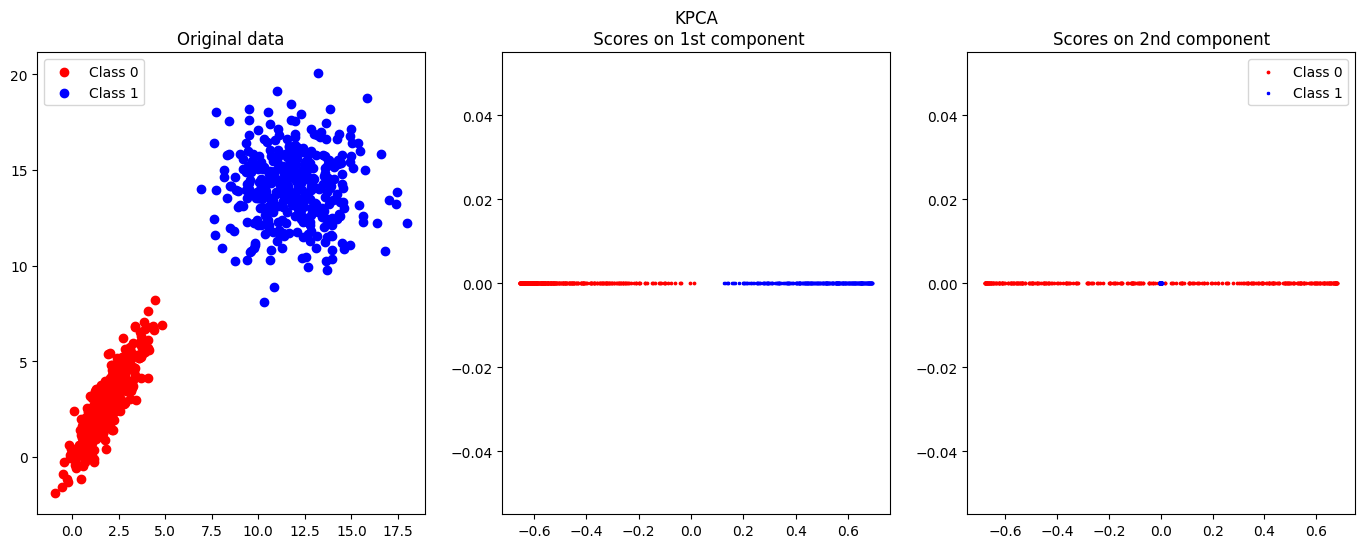

In [74]:
# Kernel-PCA
gamma=0.1
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.eigenvalues_
AKpca=Kpca.eigenvectors_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')




**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [75]:
def KpcaGaussianLecture(X,gamma):
    '''
    Inputs:
            X: is a [Nxd] matrix. Every row is an observation and every
            column is a feature.

    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the
            coordinates of \phi(X) onto the new basis given by the eigenvactors
            of the covariance matrix of \phi(X). Columns are the principal components.

            An: columns are Eigenvectors normalised (sorted from the greatest
            to the lowest eigenvalue)

            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.

    '''

    # kernel matrix using a rbf kernel
    def kernel_matrix(X,gamma):
      N=X.shape[0]
      InnerX = np.dot(X,X.T)
      temp1=np.sum(X**2,axis=1).reshape((N,1))
      temp2=np.sum(X**2,axis=1).reshape((1,N))
      Norm1 = np.repeat(temp1,N,axis=1)
      Norm2 = np.repeat(temp2,N,axis=0)
      Norm = Norm1+Norm2-2*InnerX;
      Norm[Norm<1e-10]=0;
      K=np.exp(-Norm/(2*gamma**2))
      return K

    N=X.shape[0]

    K=kernel_matrix(X, gamma)

    # center kernel matrix
    oneN=np.ones((N,N))/N;
    Kc=K - oneN@K - K@oneN + oneN@K@oneN

    # eigenvalue analysis
    D,A=LA.eigh(Kc)
    idx = D.argsort()[::-1]  # reverse order to make 'descend'
    D = np.real(D[idx])
    D[D<0]=1e-18 # make negative eigenvalues positive (and almost 0)
    A = np.real(A[:,idx])

    # variance explained
    tot=np.sum(D)
    var_explained = D/tot

    # Normalisation eigenvectors
    # Norm of every eigenvector is 1, we want it to be 1/sqrt(N*eig)

    An=np.copy(A)
    for i in range(N):
        An[:,i]=np.dot(A[:,i],(1/np.sqrt((N-1)*D[i])) )

    Y=Kc@An # computation of the scores

    return Y,An,D,var_explained


Test your own implementation

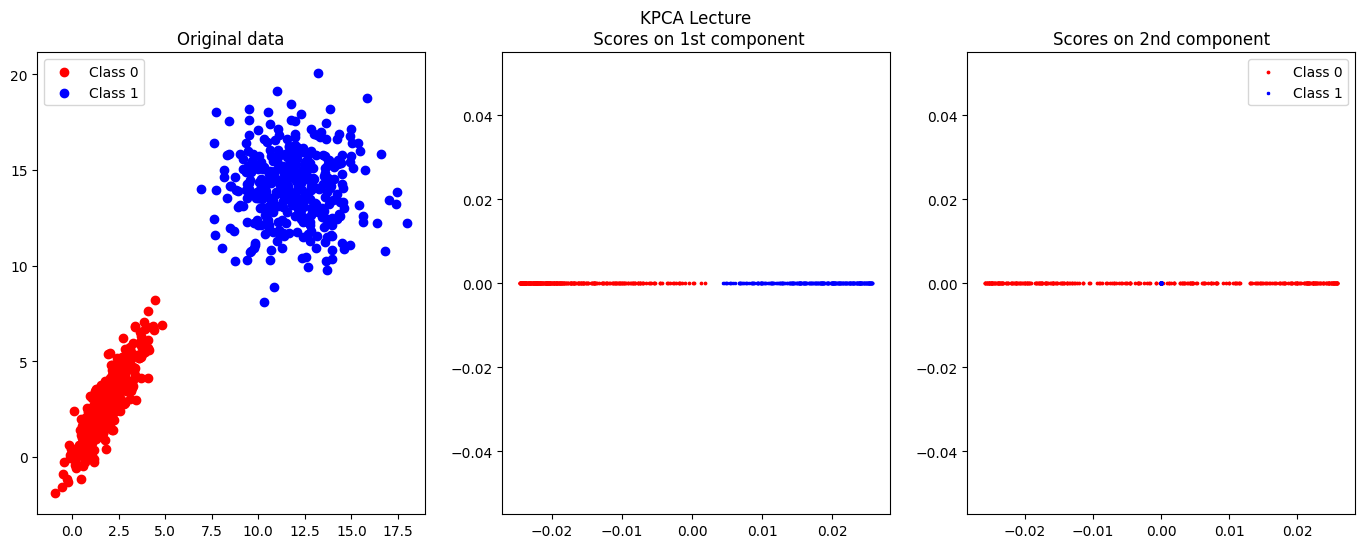

In [76]:
YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(X,2)
plotResults(X0=X0,X1=X1,y=y,Y=YKpcaLec,const=1,title='KPCA Lecture')


> On obtient ici le même résultat en prenant $\gamma=2$.

## I - 3) ICA

Now, we work on ICA, first by testing scickit-learn FastICA implementation, and then coding your own.

**Question:**
1. Use ICA with the different 4 scenarios and comment the results. When it works better than PCA ? Why ?

**Answer:**
1. ICA fonctionne mieux que le PCA pour les scénarios 2 et 3 car les deux classes sont indépendantes mais non orthogonales.

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


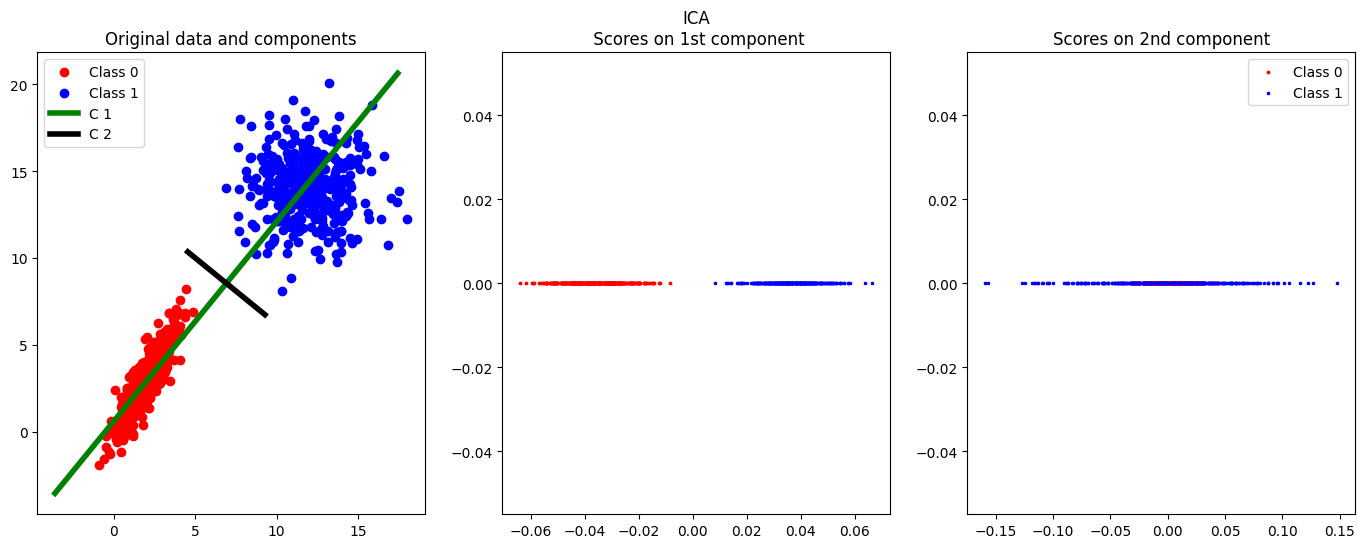

In [77]:
## ICA
ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')


**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see **XXXXXXXXXXXXXX**

In [78]:
def FastICALecture(X,N_Iter=3000,tol=1e-5,plot_evolution=0):
    '''
    Inputs:
                   X: is a [d x N] matrix. Every column is an observation
                   and every row is a feature.

                   (Optional) N_Iter: maximum number of iterations

                   (Optional) delta: convergence criteria threshold

                   (Optional) plot_evolution: plot evolution of error

     Outputs:
                   S: [d x N] matrix.  Each column is an independent component
                   of the centred and whitened input data X

                   W: [d x d] matrix. It is the demixing matrix. S = W*Xcw

    '''

    # We choose G=-exp(-1/2t^2)
    # First derivative of G
    def g(t):
        res = t*np.exp(-1/2*t**2)
        return res

    # Second derivative of G
    def gp(t):
        res = np.exp(-1/2*t**2)*(1-t**2)
        return res

    # Size of X
    d,N=X.shape

    # Compute sample mean
    mu = X.mean(axis=1, keepdims=True)

    # Center data
    Xc= X - mu

    # Compute covariance matrix
    C=np.cov(X)

    # Whiten data
    Xcw=np.linalg.inv((LA.sqrtm(C)))@Xc

    # check if are whitened
    if np.sum(np.eye(d) - np.abs(np.cov(Xcw)))>1e-10:
        raise NameError('Your whitening transformation does not work...')

    # Initialize W
    W = ortho_group.rvs(d) # random orthogonal matrix

    # delta evolution
    k = 0
    delta = np.inf
    evolutionDelta=[]

    while delta > tol and k < N_Iter:

        k = k + 1
        W_old = np.copy(W)

        Wp = g(W @ Xcw) @ Xcw.T - np.diag(gp(W @ Xcw) @ np.ones(N)) @ W
        W = np.linalg.inv(LA.sqrtm(Wp @ Wp.T)) @ Wp
        if np.sum(np.eye(d)-np.abs(np.dot(W,W.T)))>1e-10:
            raise NameError('W should be an orthogonal matrix. Check the computations')

        delta = 1-np.min(np.abs(np.diag(np.dot(W.T,W_old))))
        evolutionDelta.append(delta)

        if k==1 or k%100==0:
            print('Iteration ICA number ', k, ' out of ', N_Iter , ', delta = ', delta)


    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')


    # Independent components
    S = W@Xcw


    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)
        plt.title('Evolution of error - ICA')
        plt.show()

    return S,W,Xcw


Test your own implementation

Iteration ICA number  1  out of  3000 , delta =  0.7775797859739043
Iteration ICA number  100  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  200  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  300  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  400  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  500  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  600  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  700  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  800  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  900  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  1000  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  1100  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  1200  out of  3000 , delta =  0.8416421563959381
Iteration ICA number  1300  out of  3000 , delta =  0.8416421563959381
Iteration ICA numb

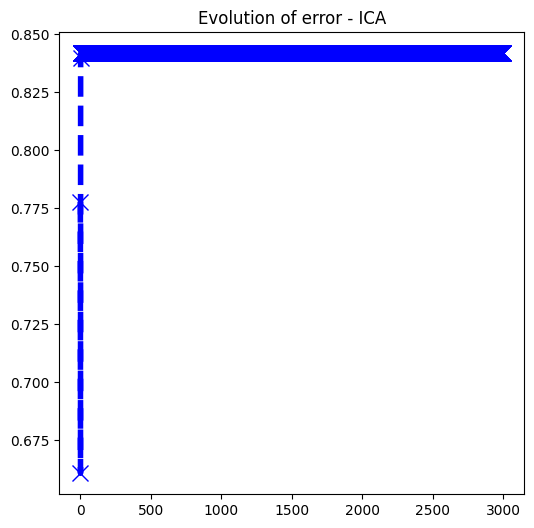

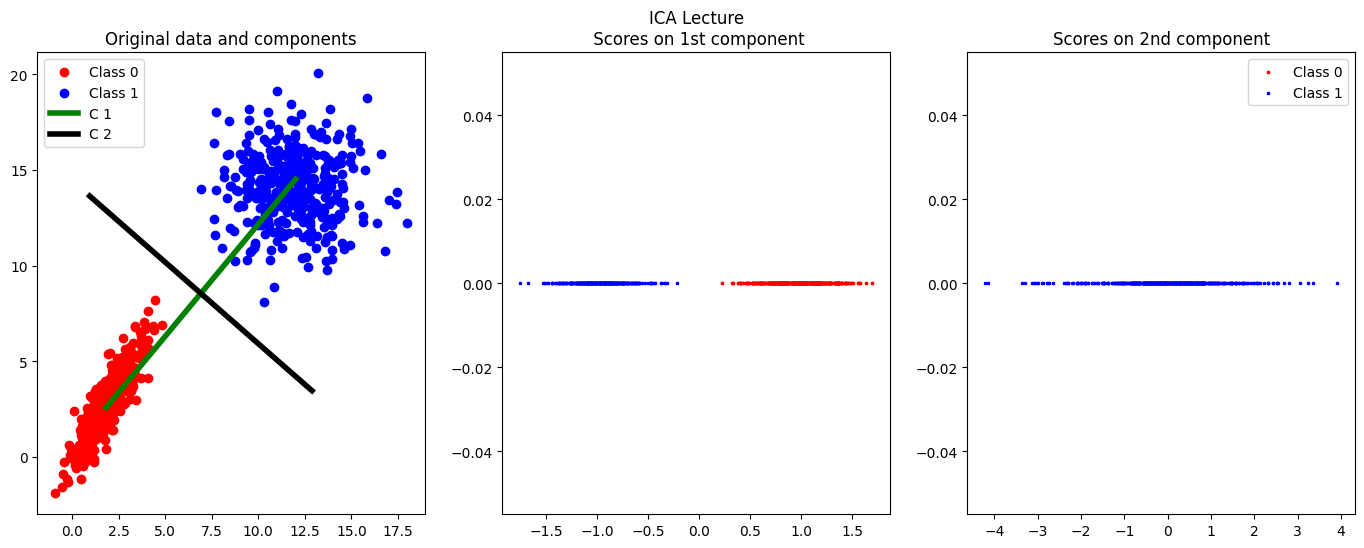

In [79]:
SicaLec,WicaLec,Xwh = FastICALecture(X.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
plotResults(X0=X0,X1=X1,y=y, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')


# II - True image dataset and face recognition
## II - 1) Dataset

**Goal**
The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning as a preprocessing for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

Let's load the data.

In [83]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./"

Below is a useful function to plot the basis images. Be careful, each row of data is a basis image.

In [84]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot


    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))

    nrow=math.ceil(len(indeces)/ncol)

    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())


Let's load the data and compute some parameters.

In [89]:
x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

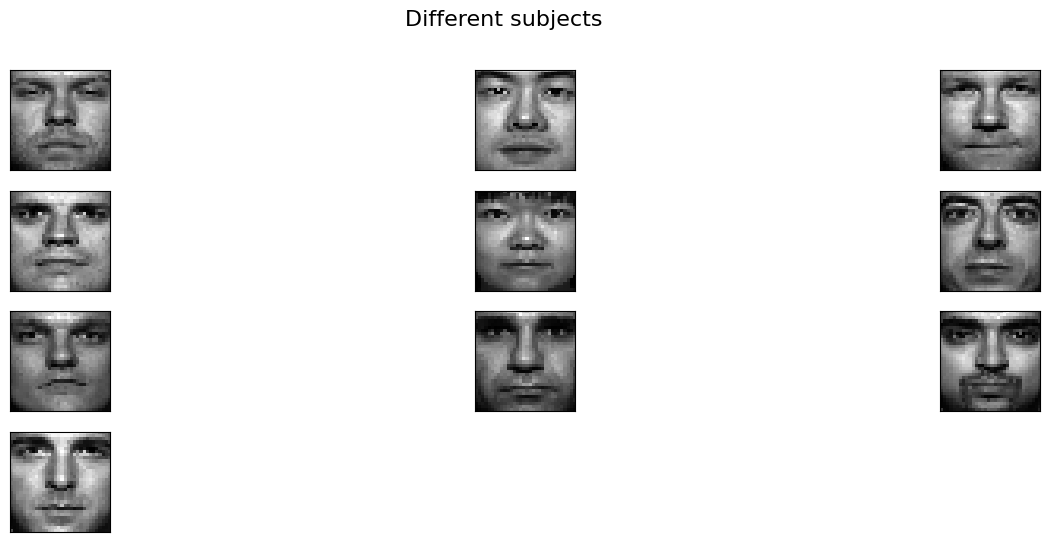

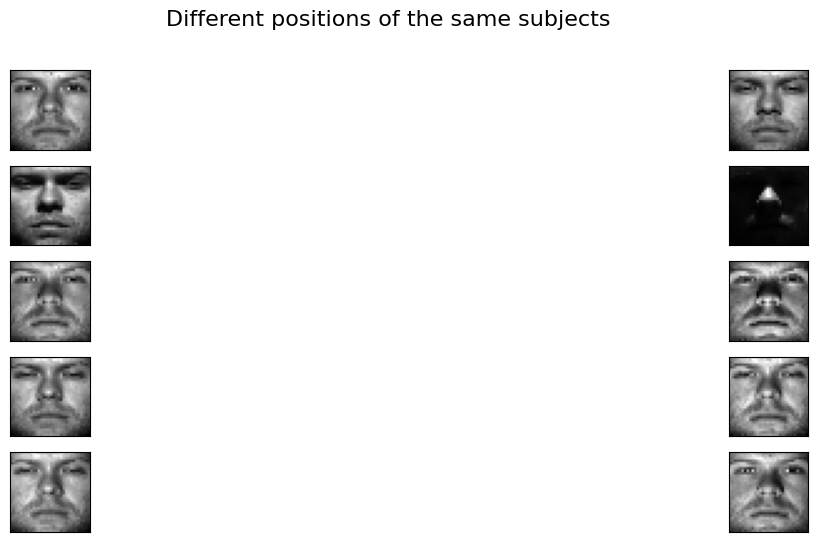

In [90]:
# Plot data
indexDifferent=np.arange(1,Is*40,Is)
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')
indexSame=np.arange(0,10,1)
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')


We can now move on to evaluate the  performance of the dimensionality reduction techniques presented this morning for face recognition. We first divide the data-set into two parts, training (80%) and test (20%) in a stratified way (subjects are divided in a balanced way between the two parts).

We will see in the next lectures why we need to divide into training and test sets. For now, just know that we will use the first set to train our algorithm and the second set to test the performance of our algorithm on new, unseen data.



In [91]:
Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest - Xtest.mean(axis=1, keepdims=True) # centering
Xctrain=Xtrain - Xtrain.mean(axis=1, keepdims=True) # centering

As first idea, we could simply use the pixel intensities as features for the classification. This is basically like using the original data, without dimensionality reducton techniques.
In the following, we will use the nearest-neighboor algorithm to perform the classification task. For each test sample, the nearest neighbor algorithm simply looks for the closest training sample and then assigns the same label (i.e. index of subject).

In [92]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('By using the pixel intensities, we use ', Xctrain.shape[1], ' features')
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))



By using the pixel intensities, we use  1024  features
Percentage of correct answer using the pixel intensities is  0.8115942028985508


# II - 2) PCA
**Preliminary part:** We can use PCA to investigate the main variations within the data.

**Question:**
1. How many modes do you need to explain at least 80% of the variability in the data ?
2. Look at the three main modes and explain which are the main variations in the data.

**Answer:**
1. Pour expliquer au moins 80% de la variation, il faut 5 modes.
2. Le premier mode semble faire varier la luminosité globale du visage, le deuxième la luminosité horizontale et le troisième la luminosité verticale.

Pour expliquer au moins 80% de la variation, il faut 5 modes.


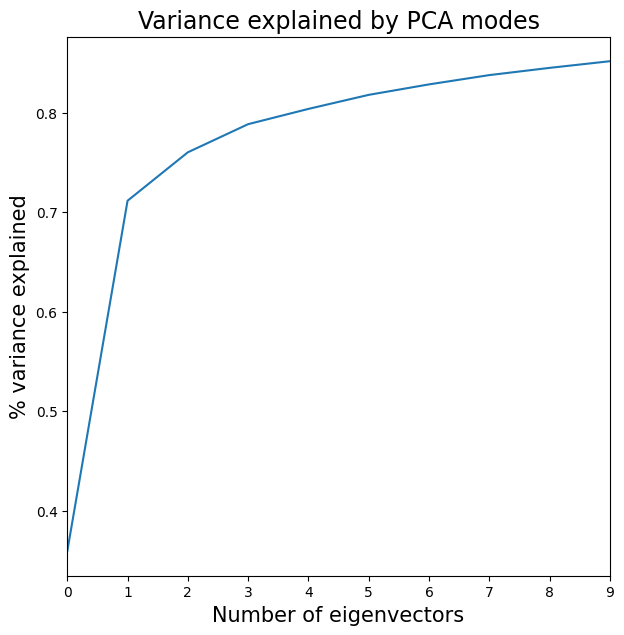

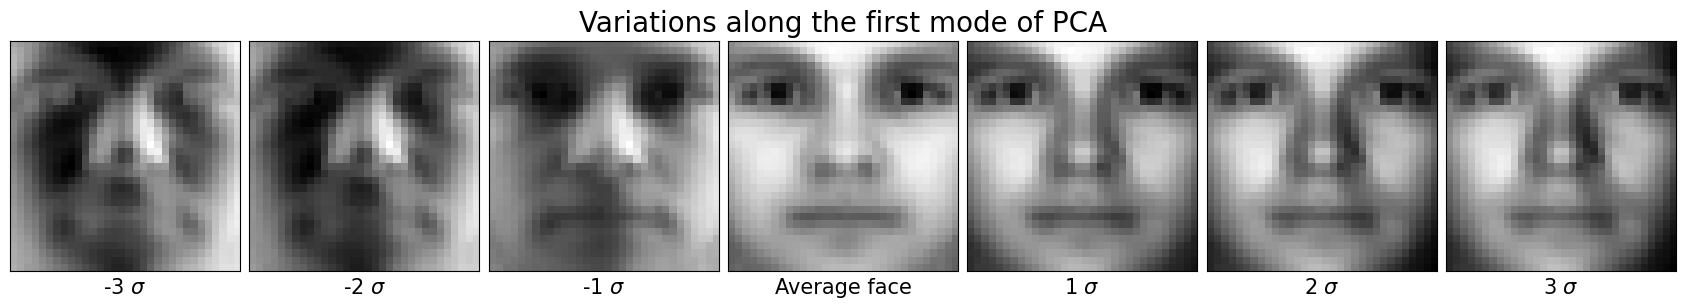

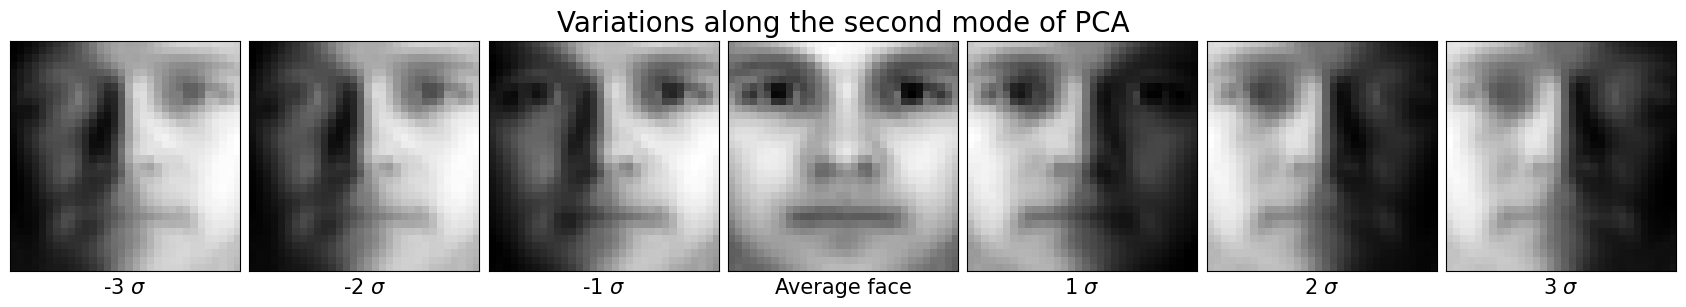

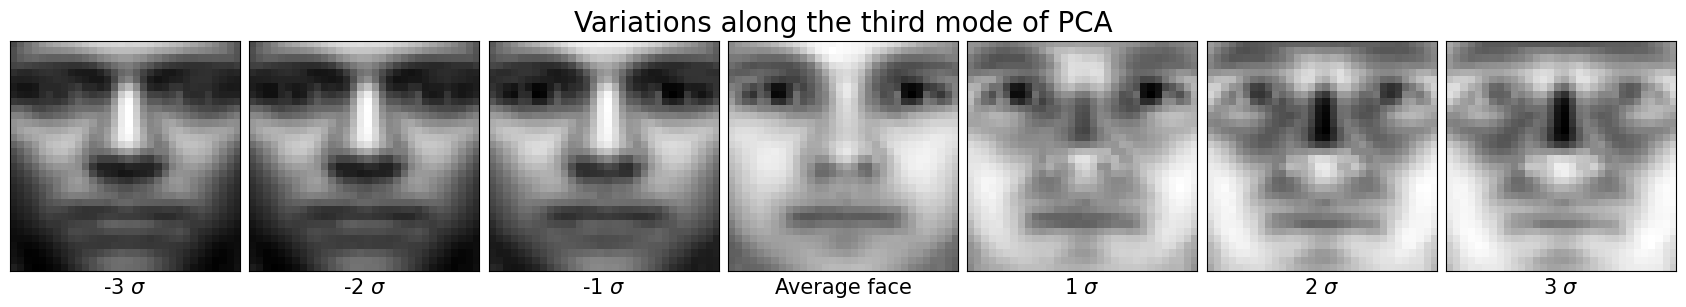

In [95]:
# Linear interpolation along the first two modes
Xm=data.mean(axis=0) # average face
YpcaTrain,UpcaTrain,DpcaTrain,var_explained_pca=pcaLecture(data)
indices=np.linspace(-3, 3, num=7, dtype=np.int16) # Interpolation indices

# Variance explained by each eigenvector
fig=plt.figure(figsize=(7, 7))
ax=plt.subplot(111)
ax.set_xlim(0, 9)
dim=np.arange(0,10,1)
cumsum_var_explained_pca = np.cumsum(var_explained_pca[:10])
plt.plot(cumsum_var_explained_pca)
plt.xticks(dim)
plt.xlabel('Number of eigenvectors',fontsize=15)
plt.ylabel('% variance explained',fontsize=15)
plt.title('Variance explained by PCA modes',fontsize=17)

## First mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the first mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[0]) * UpcaTrain[:, 0]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)


## Second mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the second mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[1]) * UpcaTrain[:, 1]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

## Third mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the third mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[2]) * UpcaTrain[:, 2]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

indice_80_percent = np.argmax(cumsum_var_explained_pca >= 0.8) + 1
print(f"Pour expliquer au moins 80% de la variation, il faut {indice_80_percent} modes.")


**PCA as a preprocessing for classification:**

Now, we can employ PCA as a preprocessing step before classification. You will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique.




Precisely, using PCA, compute the scores $Y_{train}$, eigenvectors $U_{train}$ and eigenvalues $D_{train}$ of the training set. The eigenvectors $U_{train}$ represent the basis images and they are usually called *'Eigenfaces'*. Then, project both training and test data onto the eigenvectors that explain 99$\%$ of the variability of the training set $L_{train}^{99}$. You will obtain two vectors of scores, $Y_{train}^{99}=X_{train} L_{train}^{99}$ and $Y_{test}^{99}=X_{test} L_{test}^{99}$, which you will use for evaluating the performance of the algorithm. Use the function `KNeighborsClassifier` to test the performance.

**Practical Questions:**

1. Use the scikit-learn implementation to test the performance, as previously explained. Furthermore, please comment the eigenfaces. Do they seem "real" ?

**Practical Answers:**

1. Les principales décompositions de visages obtenues sont quelque peu déformées, ce qui fait que les visages ne paraissent pas tout à fait réalistes. Pour autant, ils demeurent reconnaissables.

**Theoretical Questions:**

1. In your opinion, why do we need to center the data before computing a PCA ? If you want, you can use the previous toy examples to answer this question.
2. Let $X$ be the original data, a matrix $\left[ N,d \right]$, and $Y$ the scores of a PCA keeping all eigenvectors, which means that $Y$ is also a matrix $\left[ N,d \right]$. Are $X$ and $Y$ equal ? If not, why ? What would you use (generally speaking) in a machine learning problem ? Why ?
3. Let $x_p$ and $x_q$ be two row-vectors representing two images, $U$ an *orthogonal* matrix whose columns are the eigenvectors of $X$ and $y_p=x_pU$, $y_q=x_qU$, check that $x_px_q^T=y_py_q^T$. This shows that $Y=XU$ is a linear transformation that preserves inner products.
4. Let $C$ be the covariance matrix of $X$ and $C=UDU^T$ its eigen decomposition. Show that the covariance matrix of $Y=XU$ is $D$.

**Theoretical Answers:**

1. Je pense qu'il est nécessaire de centrer les données pour la recherche du meilleur hyperplan pour les caractériser. Si les données ne sont pas centrées, il faut chercher un hyperplan affine, ce qui est nettement plus difficile.
2. X et Y représentent les mêmes données représentées sur des bases différentes. Ainsi, ces deux matrices ne sont pas égales. Dans un problème de machine learning, il vaut mieux utiliser Y car on souhaite travailler avec la dimension la plus faible possible pour réduire la complexité.
3. $x_px_q^T=x_pUU^Tx_q^T$ car U est orthogonale. Ainsi, $x_px_q^T=x_pU(x_qU)^T=y_py_q^T$
4. $Cov(X)=C$. Ainsi, $Cov(Y)=Cov(XU)=\frac 1 N (XU)^TXU=U^TCU=\frac 1 N U^TUDu^TU= D$

PCA uses  12  features
Percentage of correct answer using PCA is  0.2857142857142857


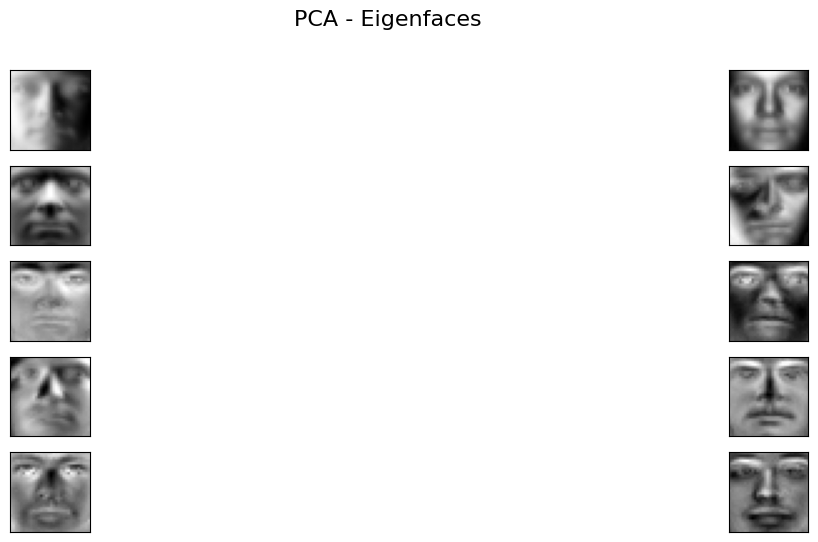

In [96]:
## PCA (scikit-learn implementation)
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(Xctrain)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(Xctrain.shape[0]-1) # computation of the eigenvalues

# Threshold defined as 99% of the variability
cumsum_var_explained_pca = np.cumsum(pca.explained_variance_ratio_)
PCAComp = np.argmax(cumsum_var_explained_pca >= 0.99) + 1

print('PCA uses ', PCAComp, ' features')

# Selection of the eigenvectors
U_selected = U[:, :PCAComp]

# Computation of the test scores using the eigenvectors computed with the
# training data-set
Yr_train_PCA = Xctrain @ U_selected
Yr_test_PCA = Xctest @ U_selected

# Plot the Eigenfaces
plotFaces(U_selected.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')

# Score: apply the nearest-neighboor algorithm to PCA output
NN.fit(Yr_train_PCA,Id_Train.ravel())
print('Percentage of correct answer using PCA is ', NN.score(Yr_test_PCA,Id_Test))



**KPCA**

In this section, we are going to do exactly the same procedure as before but using Kernel-PCA with a Gaussian kernel. Remember that we need to compute and center the test kernel matrix $[\mathbf{\tilde{K}}]_{ij}=<\phi(x_i)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)>$ and that, once computed the basis vectors in the training set $\{  \mathbf{\alpha}_i \}$, we can compute the score for a test sample $t$ using the following equation:

$y_i(t) = \sum_{j=1}^N a_{ij} <\phi(t)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)> = \sum_{j=1}^N a_{ij} \tilde{k}(t,x_j)$

Answer the following questions:

**Questions:**

1.  Use the scikit-learn implementation to test the performance
2. Look for the best gamma value
3. Why the basis vectors $\{  \mathbf{\alpha}_i \}$ are not plotted as in PCA ?
4. Is it worth it, in your opinion, to compute PCA and/or KPCA ? Why not using the original pixel intensities ? Please consider the following aspects in your answer: performance, computational time, number of features, and interpretability of the results.
5. (Optional) Create a new function `Kpca_poly_lecture` where you change the kernel to $k(x,y)=<x,y>^d$. Evaluate the performance of this new kernel.

**Answers:**

2. La meilleure valeur de gamma est 3,1.
3. On ne les affiche pas car ils sont dans une dimension supérieure que l'image originale.
4. Il me semble utile d'utiliser les algorithmes de PCA et KPCA lorsqu'ils permettent de réduire le nombre de features avant de classifier.


In [98]:
# Kernel-PCA (scikit-learn implementation)
## choose a gamma value
gamma=4

def KPCA(gamma):

  #
  # Apply K-PCA
  Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
  YKpca=Kpca.fit_transform(Xctrain)
  DKpca=Kpca.eigenvalues_
  AKpca=Kpca.eigenvectors_

  # variance explained
  cumsum_var_explained_kpca = np.cumsum(DKpca / np.sum(DKpca))

  # Threshold defined as 99% of the variability
  KPCAComp = np.argmax(cumsum_var_explained_kpca >= 0.99) + 1

  # Selection of the eigenvectors
  U_selected = AKpca[:, :KPCAComp]

  # Construction matrix K for test
  N = Xctrain.shape[0]
  M = Xctest.shape[0]
  InnerX = np.dot(Xctest,Xctrain.T)
  tempTrain=np.sum(Xctrain**2,axis=1).reshape((1,N))
  tempTest=np.sum(Xctest**2,axis=1).reshape((M,1))
  NormTrain2 = np.repeat(tempTrain,M,axis=0)
  NormTest2 = np.repeat(tempTest,N,axis=1)
  Norm = NormTest2+NormTrain2-2*InnerX
  Norm[Norm<1e-10]=0
  Ktest=np.exp(-Norm/(2*gamma**2))

  # Centering kernel test matrix
  oneN=np.ones((N,N))/N
  oneM=np.ones((M,M))/M
  KcTest=Ktest - oneM @ Ktest - Ktest @ oneN + oneM @ Ktest @ oneN # center kernel matrix

  # Computation of the test scores using the eigenvectors computed with the training data-set
  Yr_test_KPCA= KcTest @ U_selected
  Yr_train_KPCA = YKpca[:,:KPCAComp]

  print('KPCA uses ', Yr_train_KPCA.shape[0], ' features')

  # Score
  NN.fit(Yr_train_KPCA,Id_Train.ravel())
  print('Percentage of correct answer using KPCA is ', NN.score(Yr_test_KPCA,Id_Test.ravel()))
  return NN.score(Yr_test_KPCA,Id_Test.ravel())

gammas = np.arange(0.1,10, 0.2)
KPCA_scores = np.vectorize(KPCA)(gammas)
argmax = np.argmax(KPCA_scores)
print("Maximum score with KPCA is " + str(KPCA_scores[argmax]) + " with gamma = " + str(gammas[argmax]))

KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.026915113871635612
KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.026915113871635612
KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.026915113871635612
KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.028985507246376812
KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.051759834368530024
KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.10351966873706005
KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.19875776397515527
KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.2836438923395445
KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.3498964803312629
KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.4161490683229814
KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.474120082815735
KPCA uses 